In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Tensorflow imported


In [2]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#!unzip "/content/drive/Shareddrives/SIH/CNN/archive (1).zip" -d "/content/drive/Shareddrives/SIH/CNN/Data"

In [14]:
# Set your dataset directory and parameters
root_url=r'/content/drive/Shareddrives/SIH/CNN/'
data_url = root_url+'Data/Data Main/'
train_data_dir = data_url+'train'
validation_data_dir = data_url+'val'
test_data_dir = data_url+'test'
IMG_SIZE = (128,128,3)  # Xception input size
batch_size = 32
epochs = 10
num_classes = 4  # Replace with the number of terrain classes in your dataset

In [5]:
# # Data Augmentation (optional but recommended for small datasets)
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0
#     # rotation_range=20,
#     # width_shift_range=0.2,
#     # height_shift_range=0.2,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     # horizontal_flip=True,
#     # fill_mode='nearest'
# )

# validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
#Create checkpoint
checkpoint_path=root_url+"/checkpoint_path/"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

In [7]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE[0:2],
                                                               shuffle=False)

val_data=tf.keras.preprocessing.image_dataset_from_directory(validation_data_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE[0:2],
                                                               shuffle=False)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_data_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE[0:2],
                                                               shuffle=False)


Found 31571 files belonging to 4 classes.
Found 1365 files belonging to 4 classes.
Found 6769 files belonging to 4 classes.


In [8]:
classes=train_data.class_names

In [9]:
print(classes)

['Grassy', 'Marshy', 'Rocky', 'Sandy']


In [10]:
#Import required models
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
  # layers.RandomRotation(0.2),
  # layers.RandomZoom(0.2),
  # layers.RandomHeight(0.2),
  # layers.RandomWidth(0.2),
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # keep for ResNet50V2,Xception, remove for EfficientNetB0
], name ="data_augmentation")

# Setup base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
# base_model = Xception(weights='imagenet', include_top=False)

base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SIZE, name="input_layer") # shape of input image

x = data_augmentation(inputs) # augment images (only happens during training)

x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights

x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model

x = layers.Dense(512, activation='relu',name="Dense_layer")(x) # pool the outputs of the base model

x = layers.Dropout(0.5,name="Dropout_layer")(x) # pool the outputs of the base model

outputs = layers.Dense(len(classes), activation="softmax", name="output_layer")(x) # same number of outputs as classes

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [ ]:
model.summary()

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])


# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:
# Train the model with the EarlyStopping callback

# Fit
history = model.fit(train_data,
                    epochs=20, # fit for 20 epochs to keep experiments quick
                    validation_data=val_data,
                    validation_steps=len(val_data), # evaluate on smaller portion of test data
                    callbacks=[checkpoint_callback,early_stopping]) # save best model weights to file

Epoch 1/20
  6/987 [..............................] - ETA: 1:44:29 - loss: 0.3168 - accuracy: 0.8438

KeyboardInterrupt: ignored



*   Increase Learning rate(0.001-->0.01)
*   More layers
*   GlobalPool



In [ ]:
# Save the trained model
model.save(root_url+'EfficientNetB0.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on the test dataset

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

212/212 [==============================] - 25s 116ms/step - loss: 7.3942 - accuracy: 0.3854
Test Loss: 7.3942
Test Accuracy: 38.54%


In [ ]:
import matplotlib.pyplot as plt

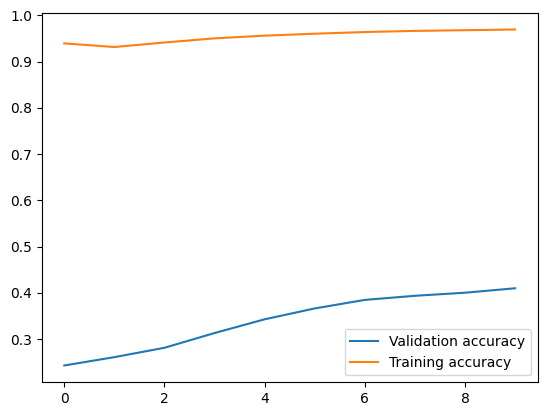

In [ ]:
plt.plot(history.history["val_accuracy"],label="Validation accuracy")
plt.plot(history.history["accuracy"],label="Training accuracy")
plt.legend()
plt.show()

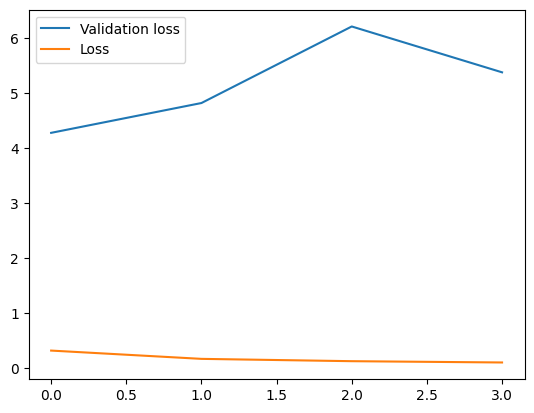

In [ ]:
plt.plot(history.history["val_loss"],label="Validation loss")
plt.plot(history.history["loss"],label="Loss")
plt.legend()
plt.show()

In [15]:
model=tf.keras.models.load_model(root_url+"Terrain_recognition_xception_model_new.h5")

In [23]:
predictions = np.array([])
labels =  np.array([])

count=300
for x, y in test_data:
  if(i==0):
    break
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
  count-=1

1/1 [==============================] - 3s 3s/step


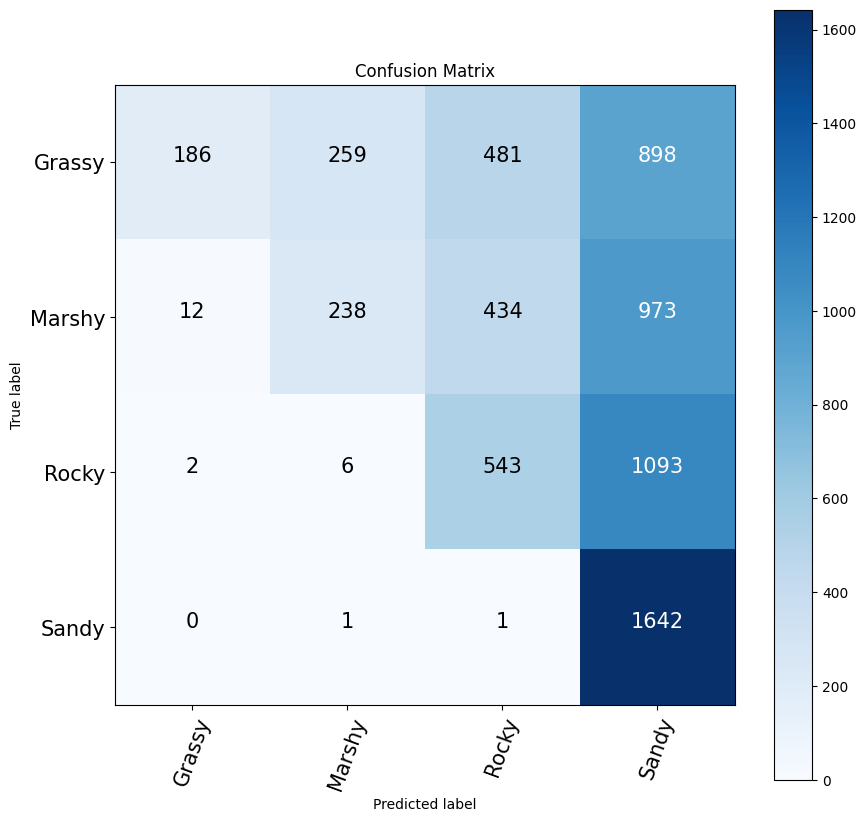

In [36]:
make_confusion_matrix(y_true=labels,y_pred=predictions,classes=classes)

In [ ]:
# loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/SIH 2023-2024/Model-Terrain/Xception learning/terrain_recognition_model.h5")

In [ ]:
#  !pip install pyngrok==4.1.1

In [ ]:
# !ngrok authtoken "my_auth_key"

In [ ]:
# !pip install flask_ngrok

In [ ]:
# #flask code
# import json
# from flask import Flask, request
# from flask_ngrok import run_with_ngrok

# app = Flask(__name__)
# run_with_ngrok(app)

# @app.route("/")
# def test_route():
#   return "homepage"

# @app.route("/api/inf/",methods=["POST"])
# def inference():
#   if request.method == "POST":
#     img_base64 = str(request.data,encoding="utf-8")
#     return "works"
#   else:
#     return "invalid request"

In [ ]:
# app.run()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/SIH 2023-2024/Model-Terrain/Xception learning/Terrain_recognition_xception_model.h5')

In [ ]:
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 1051

In [ ]:
from keras.preprocessing import image

imagePath='/content/drive/MyDrive/SIH 2023-2024/Model-Terrain/Xception learning/Data Main/val/Rocky/Rocky (1)_0_10.png'

test_image = image.load_img(imagePath, target_size = (256,256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(new_model.predict(test_image))


1/1 [==============================] - 1s 1s/step


In [ ]:
d={0:'Grassy',1:'Marshy',2:'Rocky',3:'Sandy'}
print(d[result])

Marshy
